# Metalens Optimization with FourierFields

This tutorial illustates the adjoint solver for DFT fields. Specifically, we use the `FourierFields` adjoint solver to design a metalens that maximizes the average intensity over three frequencies at a spot near the metalens. In a similar [example](https://github.com/NanoComp/meep/blob/master/python/examples/adjoint_optimization/05-Near2Far.ipynb) based on the `Near2FarFields` adjoint solver, the focal spot is far from the metalens. Compared with `Near2FarFields`, the `FourierFields` adjoint solver has some advantages, including higher efficiency for fields at nearby points and greater flexibility for surrounding media (not limited to homogeneous media surrounding far-field regions when `Near2FarFields` is applied). On the other hand, the disadvantage is that `FourierFields` is less efficient for faraway points, which require a large computational cell.

At first, let us import `meep`, its adjoint module `meep.adjoint`, and other packages for automatic differentiation, nonlinear optimization, and making figures.

In [1]:
# 필요한 라이브러리를 가져옵니다
import meep as mp  # Meep 라이브러리 (시뮬레이션용)
import meep.adjoint as mpa  # Meep의 adjoint 모듈 (역문제 관련 기능)
import numpy as np  # NumPy 라이브러리 (배열 및 수치 연산용)
from autograd import numpy as npa  # Autograd의 NumPy 라이브러리 (자동 미분용)
from autograd import tensor_jacobian_product, grad  # Autograd의 자동 미분 관련 함수들
import nlopt  # NLopt 라이브러리 (비선형 최적화용)
from matplotlib import pyplot as plt  # Matplotlib 라이브러리 (시각화용)
from matplotlib.patches import Circle  # Matplotlib의 Circle 패치 (원 그리기용)

# Meep 라이브러리의 출력 레벨을 설정합니다 (0: 출력 안 함, 1: 간결한 출력, 2: 자세한 출력)
mp.verbosity(0)

# 광섬유의 굴절률 (index)를 나타내는 매질 객체를 생성합니다
Si = mp.Medium(index=3.4)  # 굴절률이 3.4인 매질 (규소)
Air = mp.Medium(index=1.0)  # 굴절률이 1.0인 매질 (공기)

# 코드의 주요 기능을 설명드리겠습니다.
# 이 코드는 주로 광섬유 굴절률 프로파일을 바탕으로 광섬유 내에서 빛의 전파를 시뮬레이션하고,
# Autograd와 NLopt를 사용하여 역문제를 푸는 최적화 기능을 제공합니다.

# 주어진 코드만으로는 코드의 전체적인 목적이나 사용되는 함수들에 대한 상세한 설명은 알 수 없습니다.
# 더 자세한 내용은 코드가 사용되는 문맥이나 다른 부분을 참고해야 합니다.
# 각 라이브러리들의 사용법과 관련 함수들에 대해서는 해당 라이브러리의 공식 문서를 참조하는 것이 좋습니다.


Basic setup

In [2]:
resolution = 30

design_region_width = 4
design_region_height = 2
pml_size = 1.0

Sx = 2 * pml_size + design_region_width
Sy = 2 * pml_size + design_region_height + 5
cell_size = mp.Vector3(Sx, Sy)

wavelengths = np.array([1.5, 1.55, 1.6])
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

pml_layers = [mp.PML(pml_size)]

fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
source_center = [0, -(design_region_height / 2 + 1.5), 0]
source_size = mp.Vector3(Sx, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]

Nx = int(round(design_region_resolution * design_region_width)) + 1
Ny = int(round(design_region_resolution * design_region_height)) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), Air, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return projected_field.flatten()


geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    )
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
)

To use the `mpa.FourierFields` adjoint solver, we need to specify the monitor where DFT fields are evaluated. In this example, we try to focus the light at three different frequencies. The objective function is simply the intensity at the focal spot averaged over those frequencies.

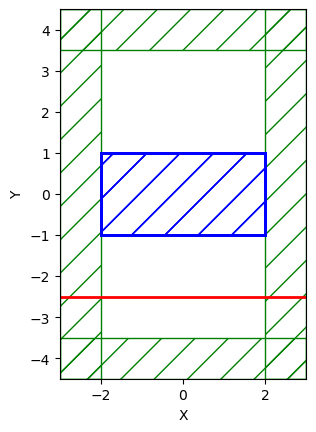

In [3]:
monitor_position, monitor_size = mp.Vector3(0,design_region_height/2+1.5), mp.Vector3(0.01,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return -npa.abs(fields[:,1]) ** 2

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    maximum_run_time=2000,
)
opt.plot2D(True)

To apply `nlopt` for nonlinear optimization, the following function is defined. This function also illustrates the structure in the design region during optimization and records the evaluation history of the objective function.

In [4]:
evaluation_history = []
cur_iter = [0]


def f(x, grad):
    t = x[0]  # "dummy" parameter
    v = x[1:]  # design parameters
    if grad.size > 0:
        grad[0] = 1
        grad[1:] = 0
    return t

In [5]:
def c(result, x, gradient, eta, beta):
    print(
        "Current iteration: {}; current eta: {}, current beta: {}".format(
            cur_iter[0], eta, beta
        )
    )

    t = x[0]  # dummy parameter
    v = x[1:]  # design parameters

    f0, dJ_du = opt([mapping(v, eta, beta)])

    # Backprop the gradients through our mapping function
    my_grad = np.zeros(dJ_du.shape)
    for k in range(opt.nf):
        my_grad[:, k] = tensor_jacobian_product(mapping, 0)(v, eta, beta, dJ_du[:, k])
        # Note that we now backpropogate the gradients at individual frequencies

    # Assign gradients
    if gradient.size > 0:
        gradient[:, 0] = -1  # gradient w.r.t. "t"
        gradient[:, 1:] = my_grad.T  # gradient w.r.t. each frequency objective

    result[:] = np.real(f0) - t

    # store results
    evaluation_history.append(np.real(f0))

    # visualize
    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    cur_iter[0] = cur_iter[0] + 1

The optimizer runs in multiple loops with increasing beta, which gradually turns on the thresholding. When beta changes, the cost function also changes, which requires the optimizer to be reset.

Current iteration: 0; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: invalid value encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)


Calculating gradient...


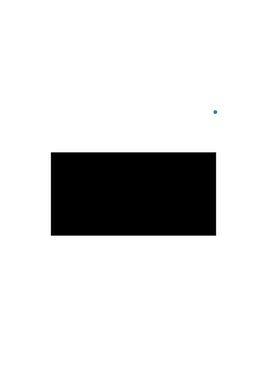

Current iteration: 1; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


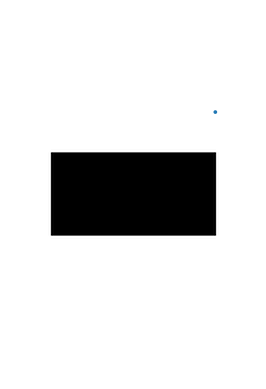

Current iteration: 2; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


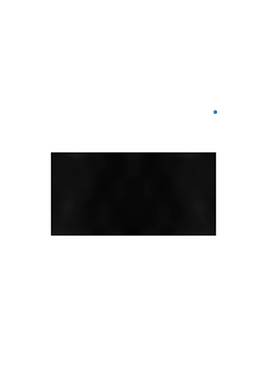

Current iteration: 3; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


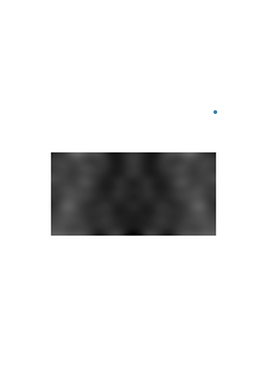

Current iteration: 4; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


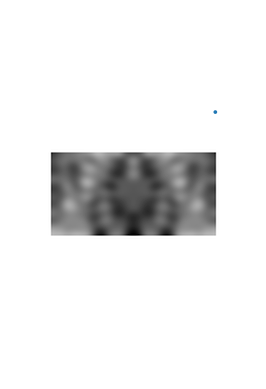

Current iteration: 5; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


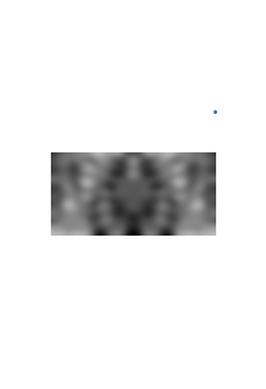

Current iteration: 6; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


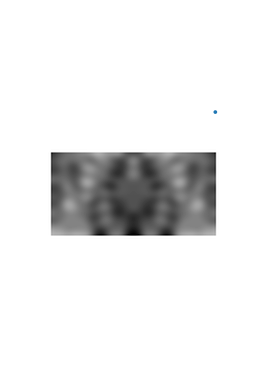

Current iteration: 7; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


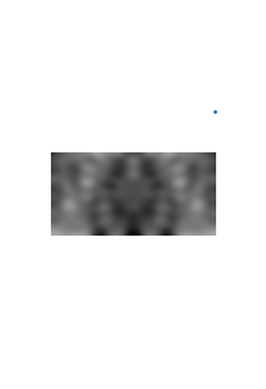

Current iteration: 8; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


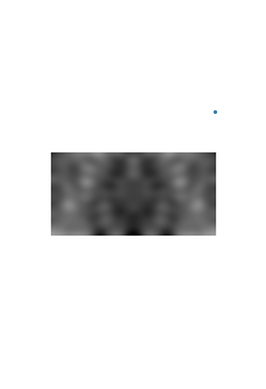

Current iteration: 9; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


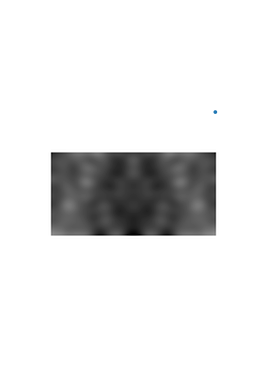

Current iteration: 10; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


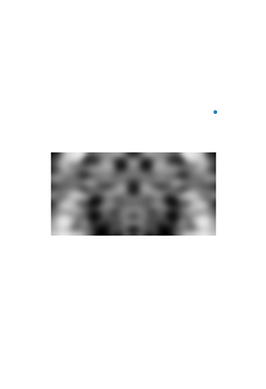

Current iteration: 11; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


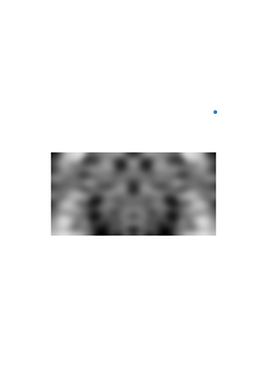

Current iteration: 12; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


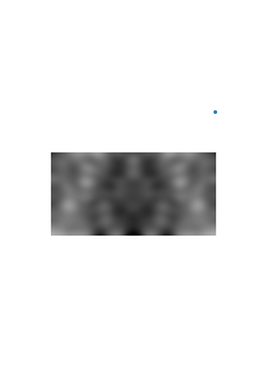

Current iteration: 13; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


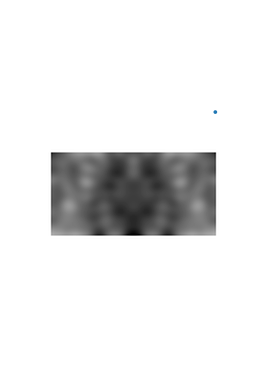

Current iteration: 14; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


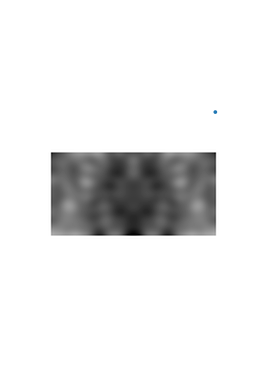

Current iteration: 15; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


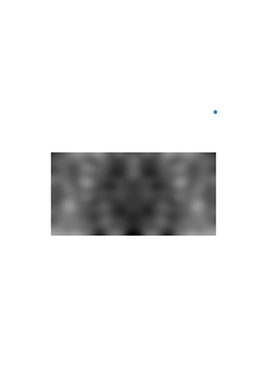

Current iteration: 16; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


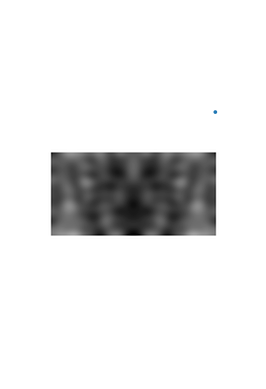

Current iteration: 17; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


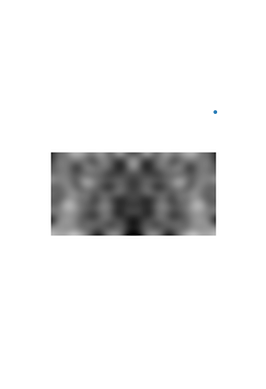

Current iteration: 18; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


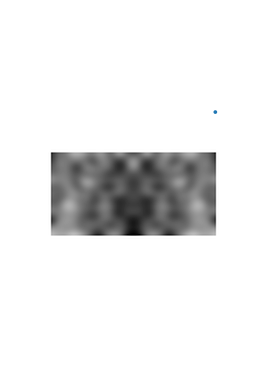

Current iteration: 19; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


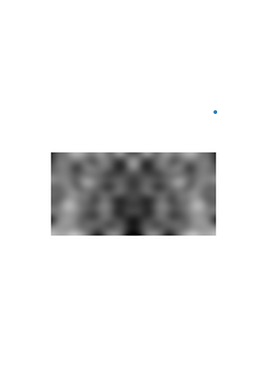

Current iteration: 20; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


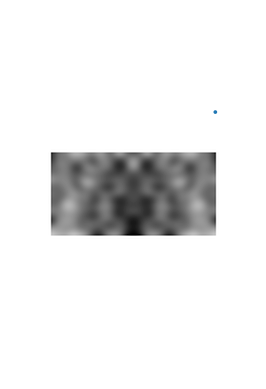

Current iteration: 21; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


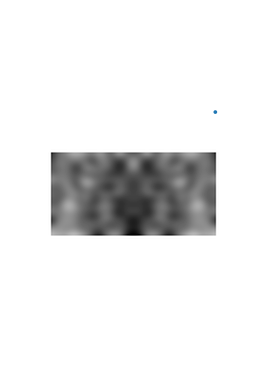

Current iteration: 22; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


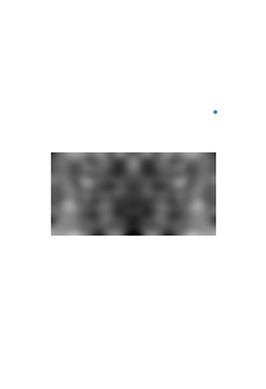

Current iteration: 23; current eta: 0.5, current beta: 6.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


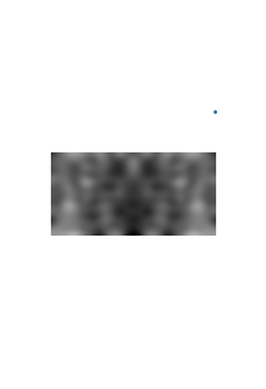

Current iteration: 24; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


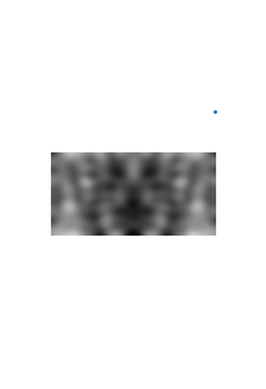

Current iteration: 25; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


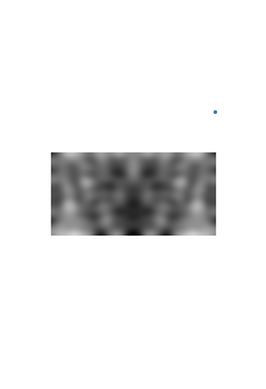

Current iteration: 26; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


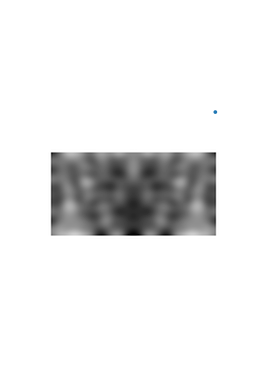

Current iteration: 27; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


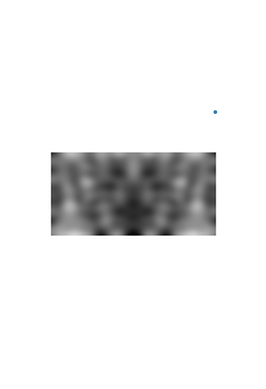

Current iteration: 28; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


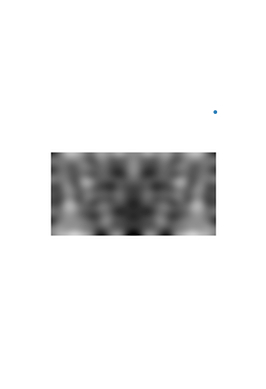

Current iteration: 29; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


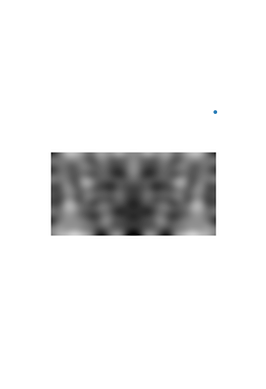

Current iteration: 30; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


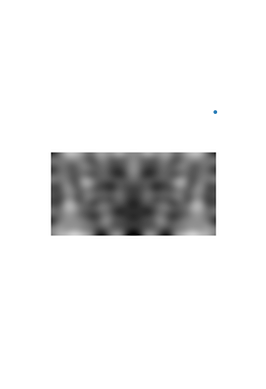

Current iteration: 31; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


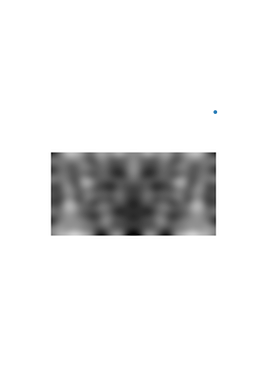

Current iteration: 32; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


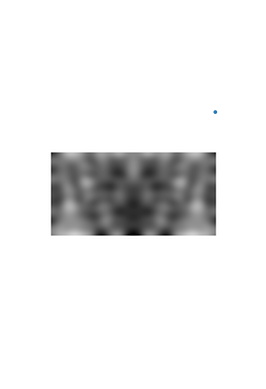

Current iteration: 33; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


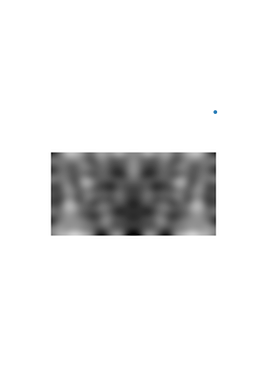

Current iteration: 34; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


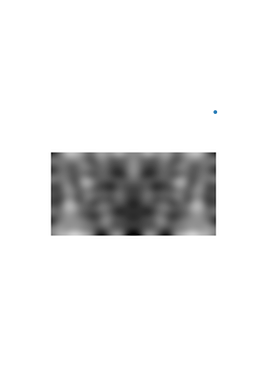

Current iteration: 35; current eta: 0.5, current beta: 9.0
Starting forward run...
Starting adjoint run...
Calculating gradient...


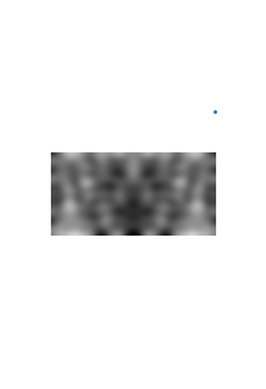

Current iteration: 36; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


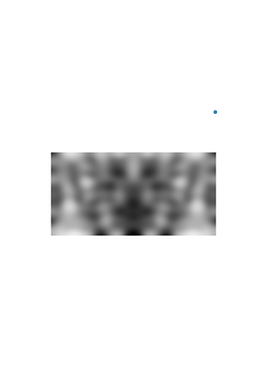

Current iteration: 37; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


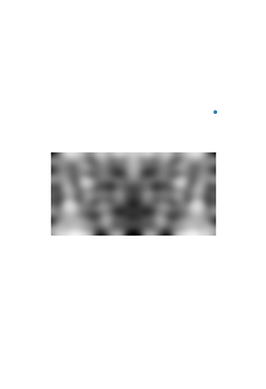

Current iteration: 38; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


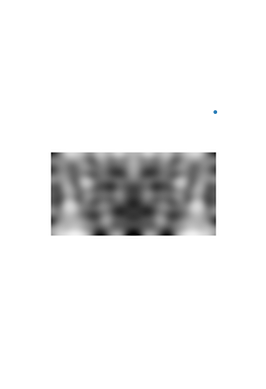

Current iteration: 39; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


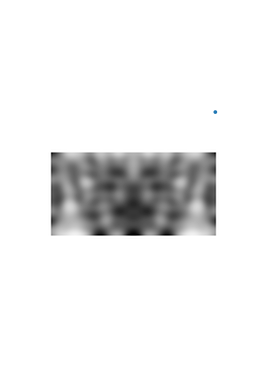

Current iteration: 40; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


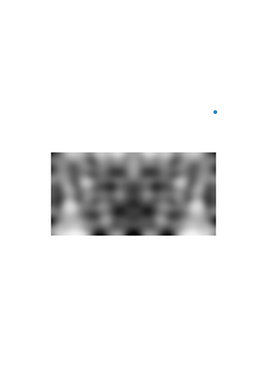

Current iteration: 41; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


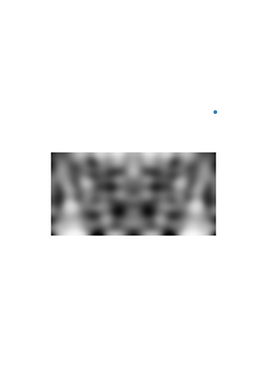

Current iteration: 42; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


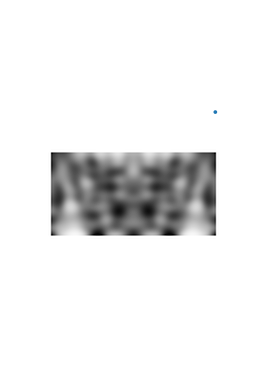

Current iteration: 43; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


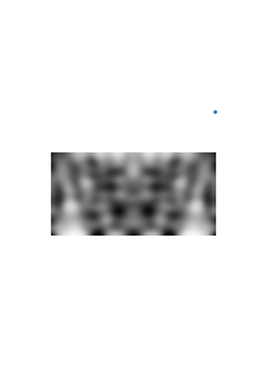

Current iteration: 44; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


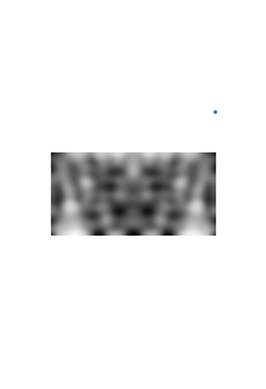

Current iteration: 45; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


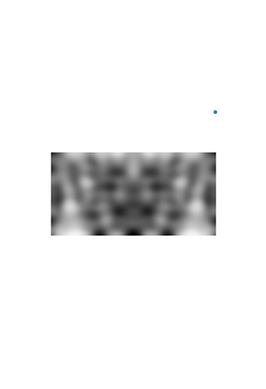

Current iteration: 46; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


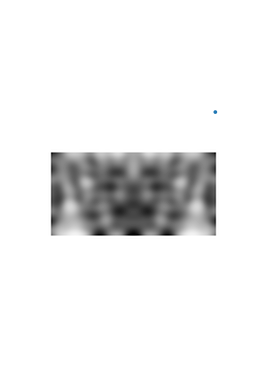

Current iteration: 47; current eta: 0.5, current beta: 13.5
Starting forward run...
Starting adjoint run...
Calculating gradient...


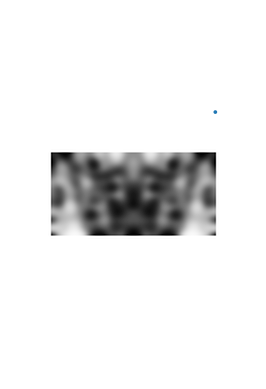

Current iteration: 48; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


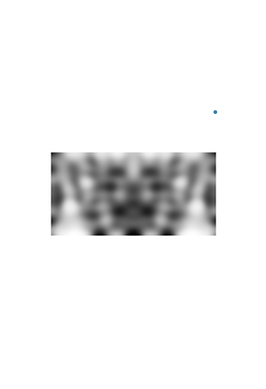

Current iteration: 49; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


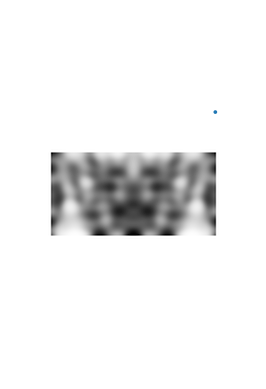

Current iteration: 50; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


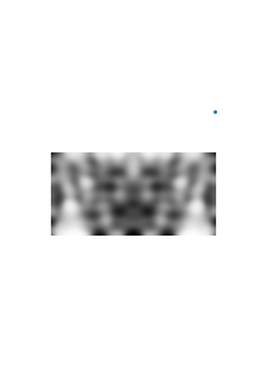

Current iteration: 51; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


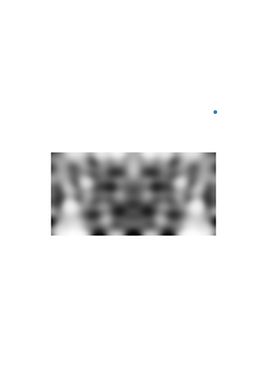

Current iteration: 52; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


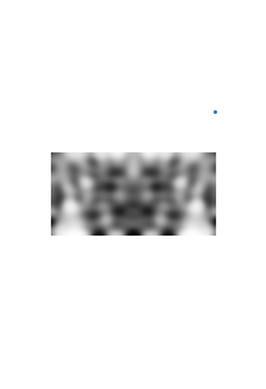

Current iteration: 53; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


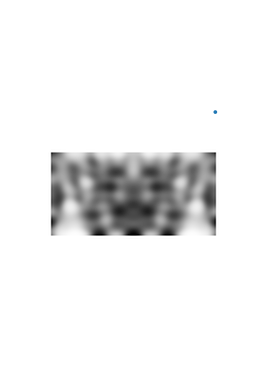

Current iteration: 54; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


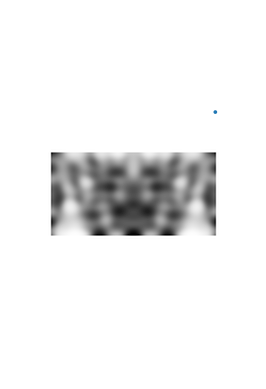

Current iteration: 55; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


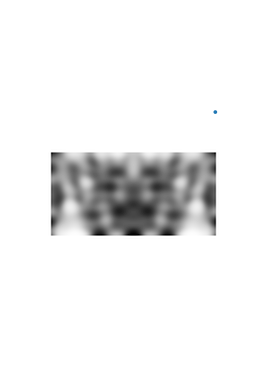

Current iteration: 56; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


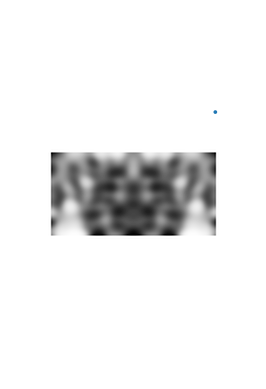

Current iteration: 57; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


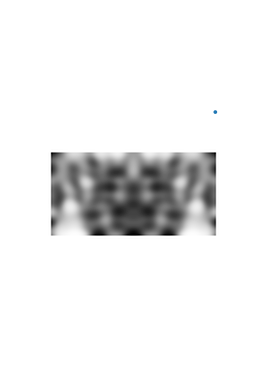

Current iteration: 58; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


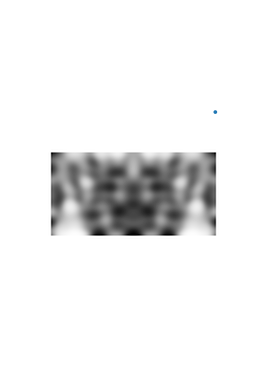

Current iteration: 59; current eta: 0.5, current beta: 20.25
Starting forward run...
Starting adjoint run...
Calculating gradient...


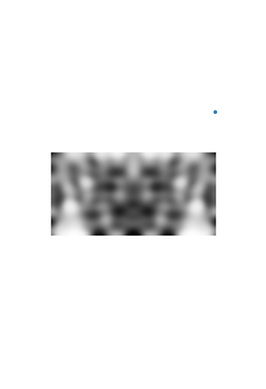

Current iteration: 60; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


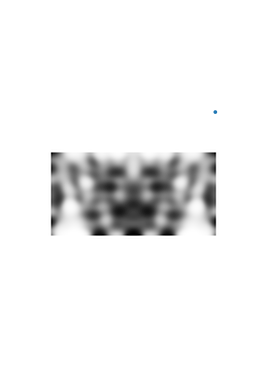

Current iteration: 61; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


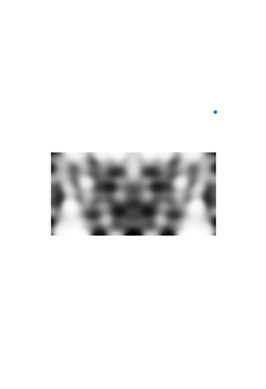

Current iteration: 62; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


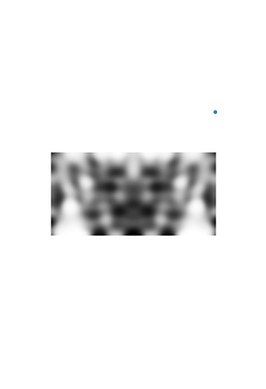

Current iteration: 63; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


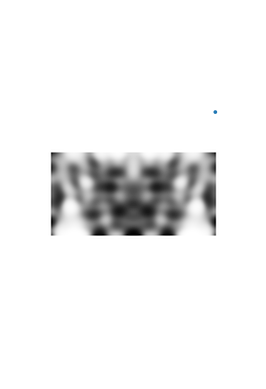

Current iteration: 64; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


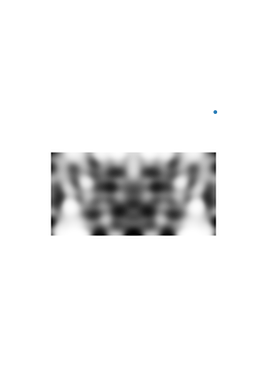

Current iteration: 65; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


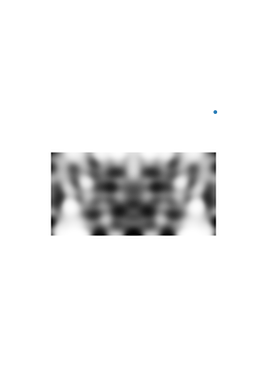

Current iteration: 66; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


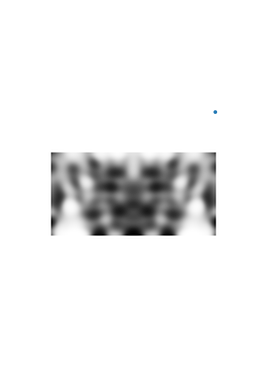

Current iteration: 67; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


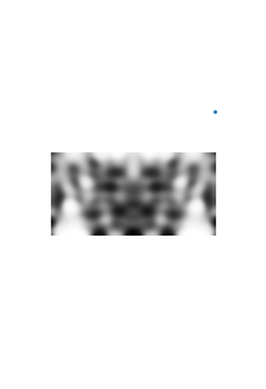

Current iteration: 68; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


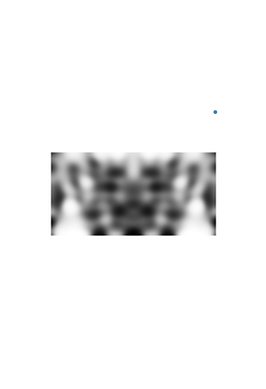

Current iteration: 69; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


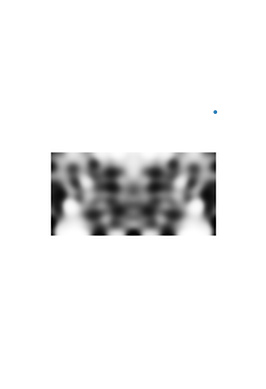

Current iteration: 70; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


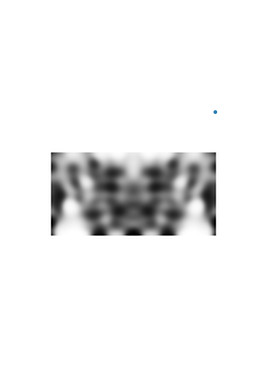

Current iteration: 71; current eta: 0.5, current beta: 30.375
Starting forward run...
Starting adjoint run...
Calculating gradient...


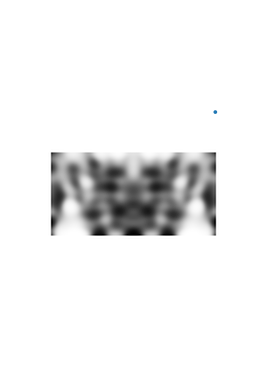

Current iteration: 72; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


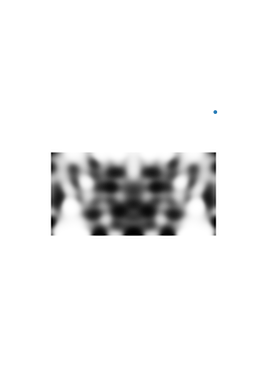

Current iteration: 73; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


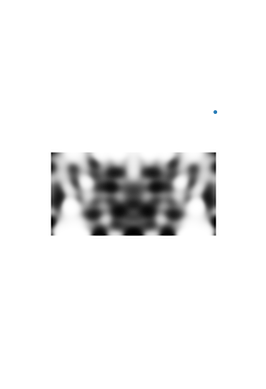

Current iteration: 74; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


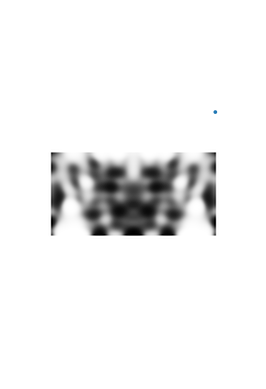

Current iteration: 75; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


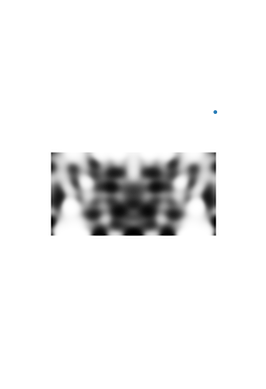

Current iteration: 76; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


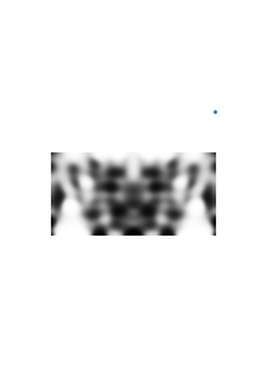

Current iteration: 77; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


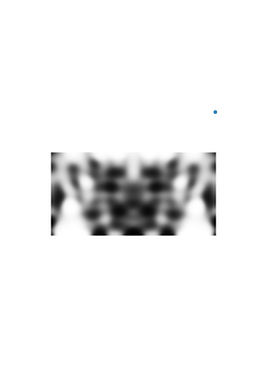

Current iteration: 78; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


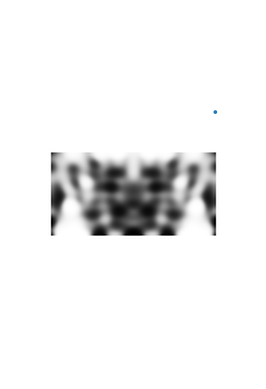

Current iteration: 79; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


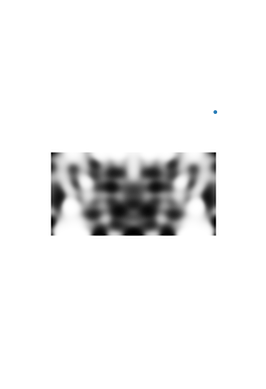

Current iteration: 80; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


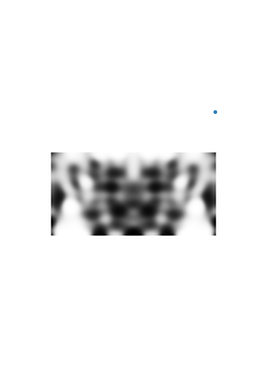

Current iteration: 81; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


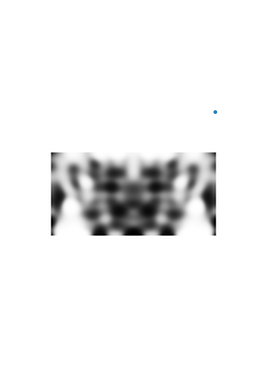

Current iteration: 82; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


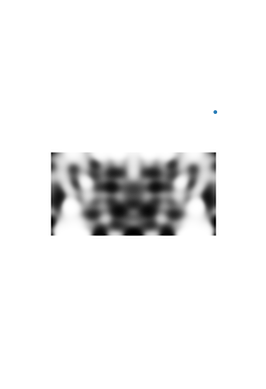

Current iteration: 83; current eta: 0.5, current beta: 45.5625
Starting forward run...
Starting adjoint run...
Calculating gradient...


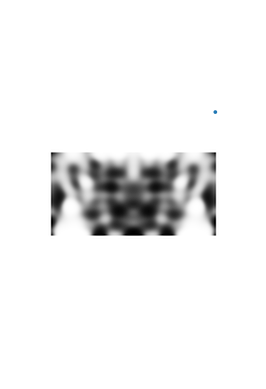

Current iteration: 84; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


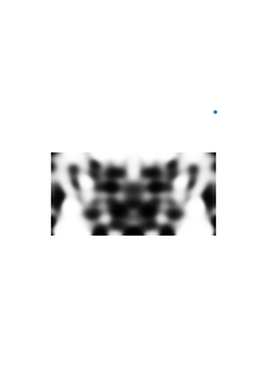

Current iteration: 85; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


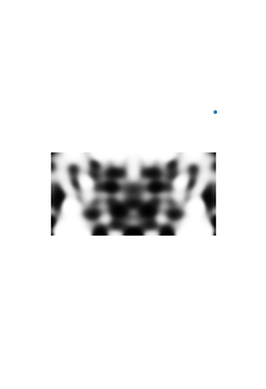

Current iteration: 86; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


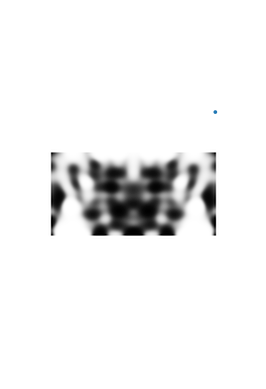

Current iteration: 87; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


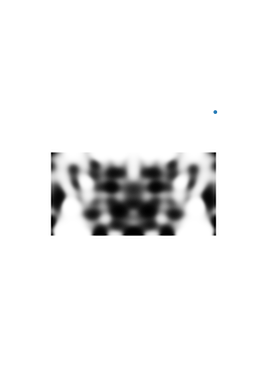

Current iteration: 88; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


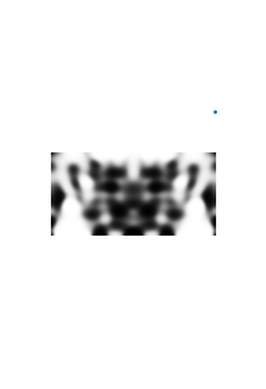

Current iteration: 89; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


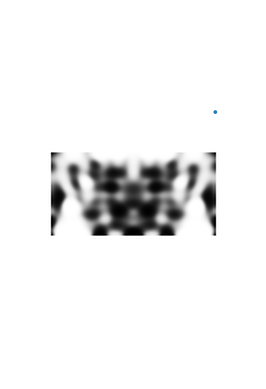

Current iteration: 90; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


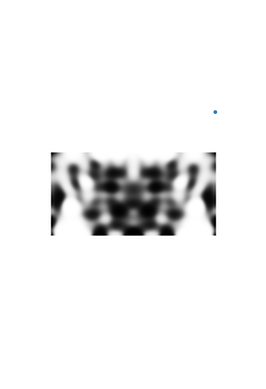

Current iteration: 91; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


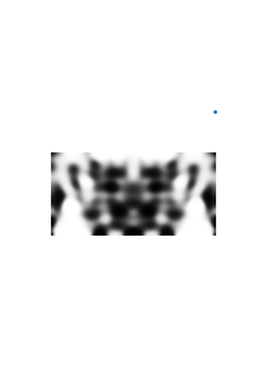

Current iteration: 92; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


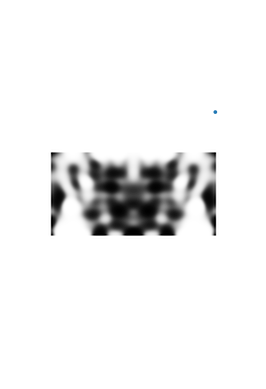

Current iteration: 93; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


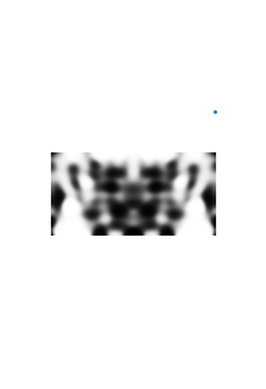

Current iteration: 94; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


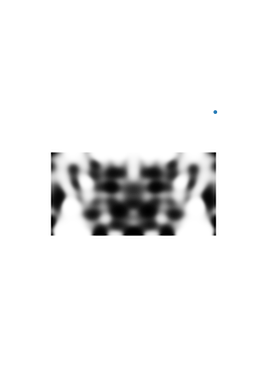

Current iteration: 95; current eta: 0.5, current beta: 68.34375
Starting forward run...
Starting adjoint run...
Calculating gradient...


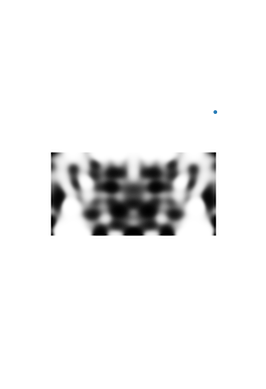

Current iteration: 96; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


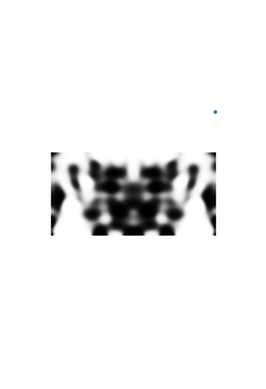

Current iteration: 97; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


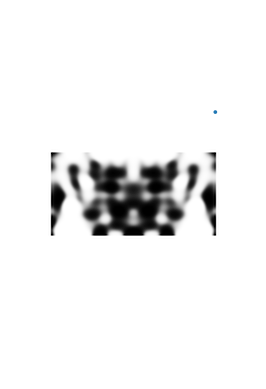

Current iteration: 98; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


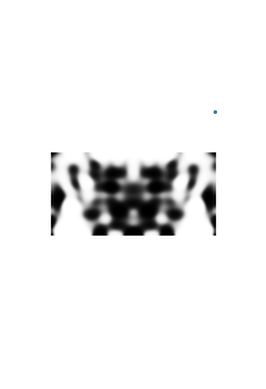

Current iteration: 99; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


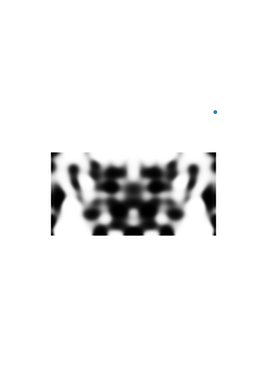

Current iteration: 100; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


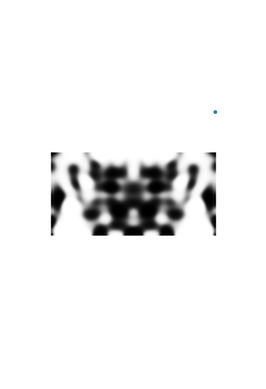

Current iteration: 101; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


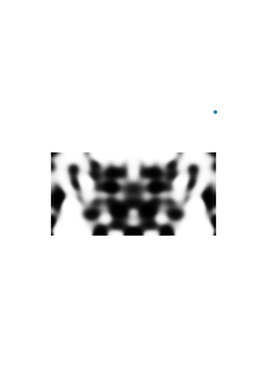

Current iteration: 102; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


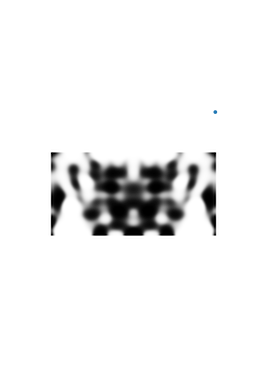

Current iteration: 103; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


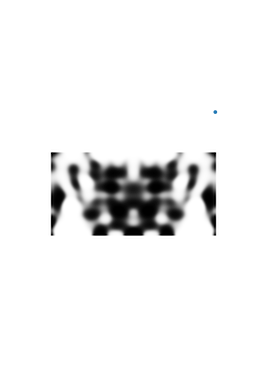

Current iteration: 104; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


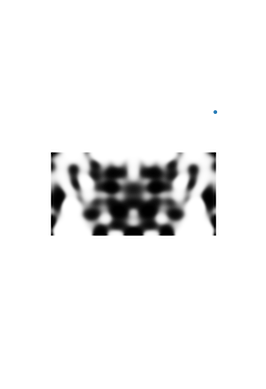

Current iteration: 105; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


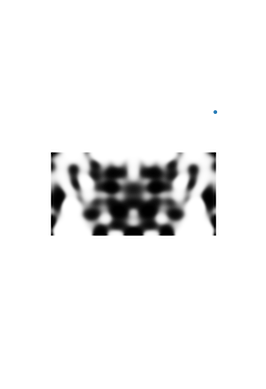

Current iteration: 106; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


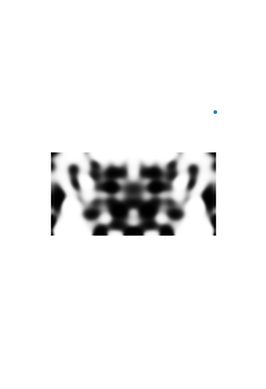

Current iteration: 107; current eta: 0.5, current beta: 102.515625
Starting forward run...
Starting adjoint run...
Calculating gradient...


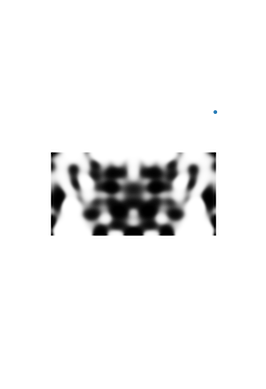

In [6]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

# insert dummy parameter bounds and variable
x = np.insert(x, 0, -1)  # our initial guess for the worst error
lb = np.insert(lb, 0, -np.inf)
ub = np.insert(ub, 0, 0)

cur_beta = 4
beta_scale = 1.5
num_betas = 9
update_factor = 12
ftol = 1e-5

for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n + 1)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_min_objective(lambda a, g: f(a, g))
    solver.set_maxeval(update_factor)
    solver.add_inequality_mconstraint(
        lambda r, x, g: c(r, x, g, eta_i, cur_beta), np.array([1e-3] * nf)
    )
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

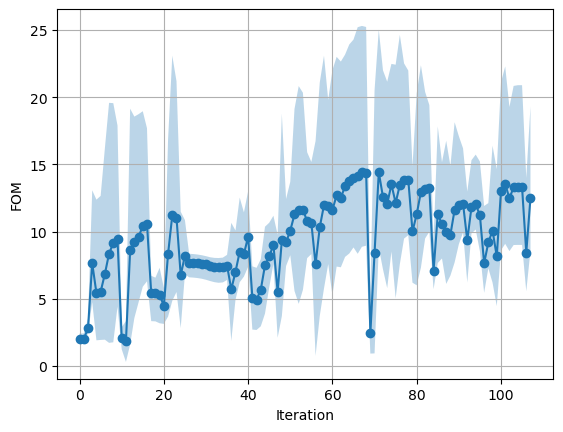

In [14]:
lb = -np.min(evaluation_history, axis=1)
ub = -np.max(evaluation_history, axis=1)
mean = -np.mean(evaluation_history, axis=1)

num_iters = lb.size

plt.figure()
plt.fill_between(np.arange(num_iters), ub, lb, alpha=0.3)
plt.plot(mean, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

We can plot the optimized geometry.

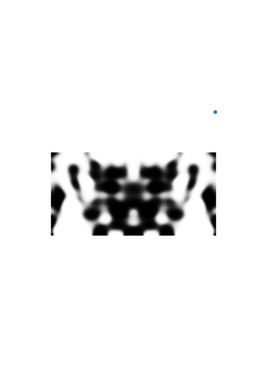

In [8]:
opt.update_design([mapping(x[1:], eta_i, cur_beta)])
plt.figure()
ax = plt.gca()
opt.plot2D(
    False,
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

To check the performance of our final structure, we plot $|E_z|^2$ at those three frequencies. Because our objective function only concerns the average of intensities, the optimizer does not necessarily maximize the performance at every frequency.

In [9]:
f0, dJ_du = opt([mapping(x[1:], eta_i, cur_beta // 2)], need_gradient=False)
frequencies = opt.frequencies

Starting forward run...


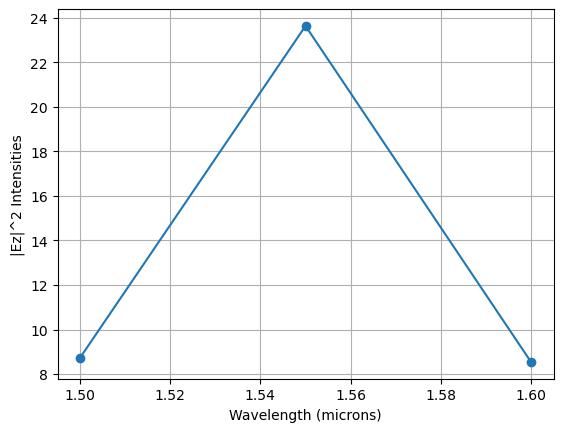

In [10]:
intensities = np.abs(opt.get_objective_arguments()[0][:, 1]) ** 2

plt.figure()
plt.plot(1 / frequencies, intensities, "-o")
plt.grid(True)
plt.xlabel("Wavelength (microns)")
plt.ylabel("|Ez|^2 Intensities")
plt.show()

Let us launch continuous-wave sources at individual frequencies and illustrate the fields.

FloatProgress(value=0.0, description='0% done ', max=300.0)

FloatProgress(value=0.0, description='0% done ', max=300.0)

FloatProgress(value=0.0, description='0% done ', max=300.0)

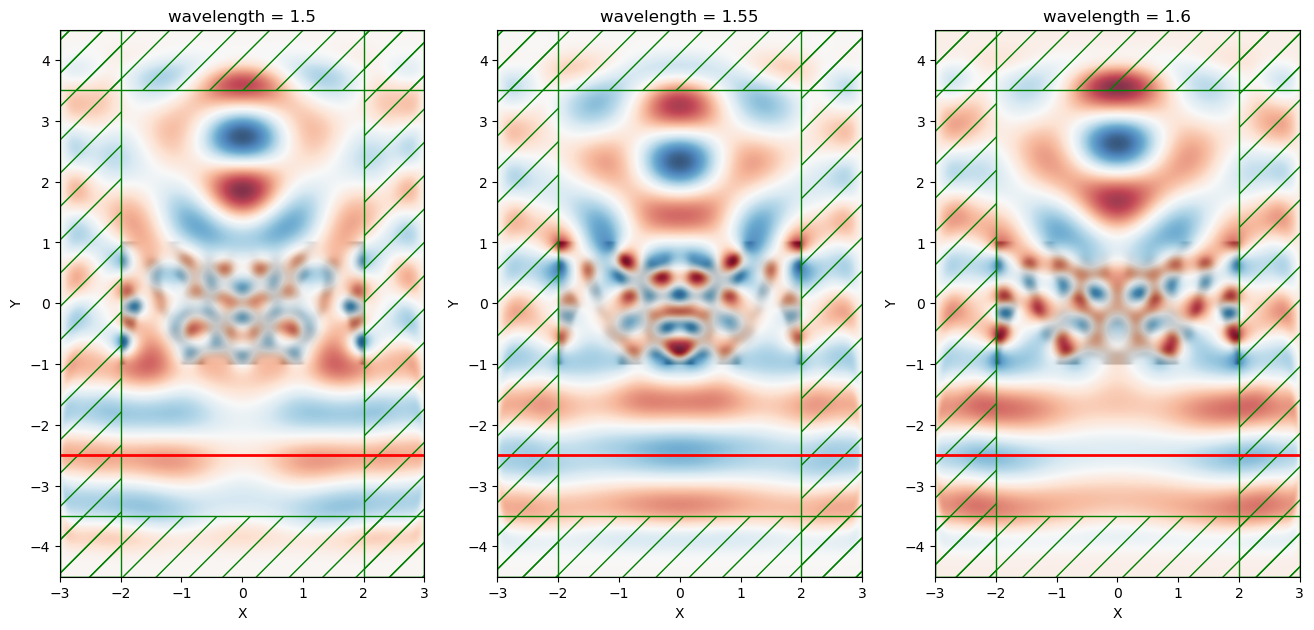

In [11]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
)
src = mp.ContinuousSource(frequency=frequencies[0], fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

plt.subplot(1,3,1)
plt.title('wavelength = '+str(wavelengths[0]))
opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
)

src = mp.ContinuousSource(frequency=frequencies[1], fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.subplot(1,3,2)
plt.title('wavelength = '+str(wavelengths[1]))
opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()

opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
)

src = mp.ContinuousSource(frequency=frequencies[2], fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]
opt.sim.change_sources(source)

plt.subplot(1,3,3)
plt.title('wavelength = '+str(wavelengths[2]))
opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()